In [1]:
import matplotlib.pyplot as plt
import os, os.path
import glob
import pickle
import numpy as np
from numpy.polynomial import Polynomial
from scipy import ndimage, signal, interpolate
#import matplotlib
#matplotlib.use('PDF')
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014
from galpy.util import bovy_conversion, save_pickles, bovy_coords, bovy_plot
#import pal5_util_old as pal5_util
import gd1_util 
#import custom_stripping_df
import seaborn as sns
import astropy.units as u
from galpy import potential
%pylab inline
from matplotlib import cm, pyplot
import SCFbar_util_new
from gd1_util_MWhaloshape import phi12_to_lb_6d, lb_to_phi12
import spiralarms_util
from galpy.potential import evaluatezforces


ro=8.
vo=220.

def galcencyl_to_lbd(R,phi,Z,degree=True):
        xyz=bovy_coords.galcencyl_to_XYZ(R,phi,Z)
        l=[]
        b=[]
        d=[]
        for ii in range(len(xyz)):
            lbd=bovy_coords.XYZ_to_lbd(xyz[ii][0],xyz[ii][1],xyz[ii][2],degree=degree)
            l.append(lbd[0])
            b.append(lbd[1])
            d.append(lbd[2])
            
        return (l,b,d)


Populating the interactive namespace from numpy and matplotlib


### Setup the bar + spiral potential

In [2]:
#n=9, l=19
Ac,As=SCFbar_util_new.compute_Acos_Asin()

barpot,nobarpot=SCFbar_util_new.MWPotentialSCFbar_grow(mbar=10.**10.,Acos=Ac,Asin=As,pat_speed=39.,fin_phi_deg=27.,t_on=-5.,tgrow=2,tstream=3.2)

spiral_pot=spiralarms_util.spiral_only_potential(tstream=3.2,axi_pot=nobarpot,N=4)

MW_bar_spiral_pot=barpot+[spiral_pot]

not growing spiral


### Run some sanity checks

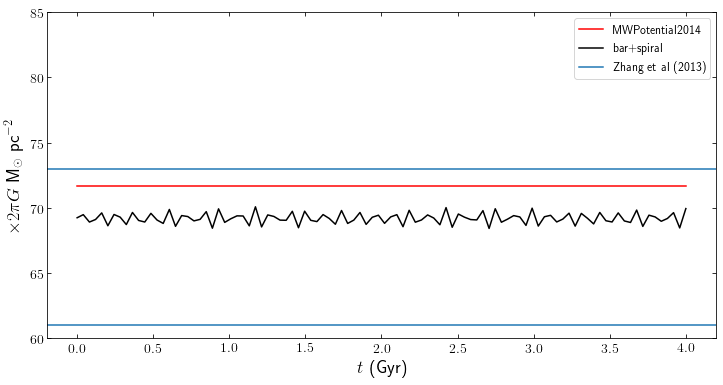

In [3]:
#vertical force at the Sun

tt=np.linspace(0.,4.,100)/bovy_conversion.time_in_Gyr(220.,8.)

Fz_MW2014 = [-evaluatezforces(MWPotential2014, 1.,1.1/8.,phi=0.,t=ii)*bovy_conversion.force_in_2piGmsolpc2(220.,8.)
            for ii in tt]

Fz_bar_spiral = [-evaluatezforces(MW_bar_spiral_pot, 1.,1.1/8.,phi=0.,t=ii)*bovy_conversion.force_in_2piGmsolpc2(220.,8.)
            for ii in tt]

bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(12,6)
plot(tt*bovy_conversion.time_in_Gyr(220.,8.),Fz_MW2014,c='r',label='MWPotential2014')
plot(tt*bovy_conversion.time_in_Gyr(220.,8.),Fz_bar_spiral,c='k',label='bar+spiral')
axhline(67.+6.,label='Zhang et al (2013)')
axhline(67-6.)
ylim(60.,85.)
legend(loc='upper right')
xlabel(r'$t$ (Gyr)')
ylabel(r'$\times 2\pi G$ M$_{\odot}$ pc$^{-2}$')
plt.show()


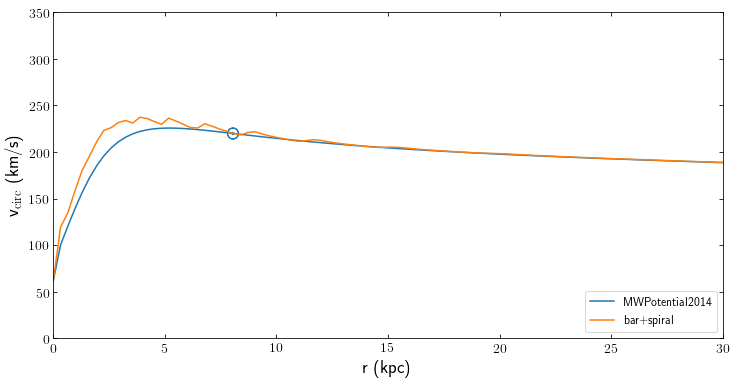

In [4]:
#circular velocity

rr=np.linspace(0.001,4.,100)

vc_bar_spiral=[potential.vcirc(MW_bar_spiral_pot,jj,phi=0)*vo for jj in rr]

plot(rr*8.,potential.vcirc(MWPotential2014,rr,phi=0)*vo,label='MWPotential2014')
plot(rr*8.,vc_bar_spiral,label='bar+spiral')
    
       
plt.legend(loc='lower right')
plt.scatter(8.,220.,s=150,marker=r'$\odot$')
plt.ylim(0,350)
plt.xlim(0,30)
plt.xlabel(r'r (kpc)')
plt.ylabel(r'v$_{\rm{circ}}$ (km/s)')
#bovy_plot.bovy_end_print('plots/vcirc_varyMbar.pdf')
plt.show()

/home/nil/anaconda3/envs/galpy1.4/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'aspect'
  s)

/home/nil/anaconda3/envs/galpy1.4/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'aspect'
  s)

/home/nil/anaconda3/envs/galpy1.4/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'aspect'
  s)

/home/nil/anaconda3/envs/galpy1.4/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'aspect'
  s)



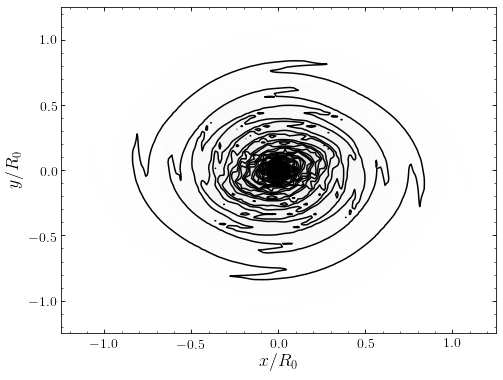

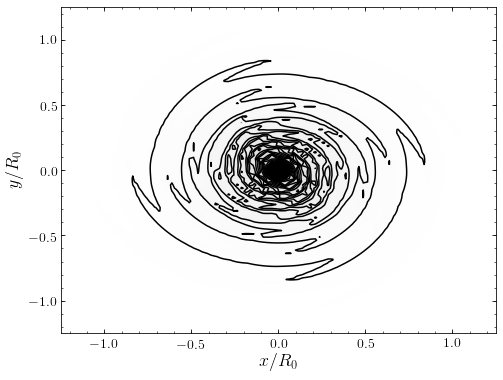

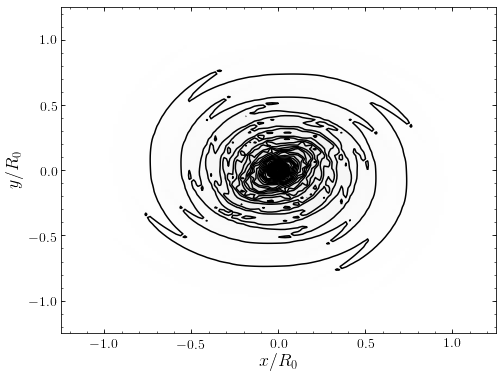

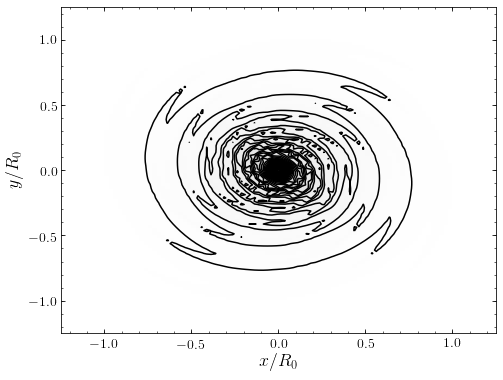

In [5]:
#plot density contours
potential.plotDensities(MW_bar_spiral_pot,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmin=-10.*u.kpc,zmax=10.*u.kpc,nrs=100,nzs=100,t=0.0*u.Gyr,xy=True,ncontours=120)
potential.plotDensities(MW_bar_spiral_pot,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmin=-10.*u.kpc,zmax=10.*u.kpc,nrs=100,nzs=100,t=0.2*u.Gyr,xy=True,ncontours=120)
potential.plotDensities(MW_bar_spiral_pot,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmin=-10.*u.kpc,zmax=10.*u.kpc,nrs=100,nzs=100,t=0.4*u.Gyr,xy=True,ncontours=120)
potential.plotDensities(MW_bar_spiral_pot,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmin=-10.*u.kpc,zmax=10.*u.kpc,nrs=100,nzs=100,t=0.6*u.Gyr,xy=True,ncontours=120)

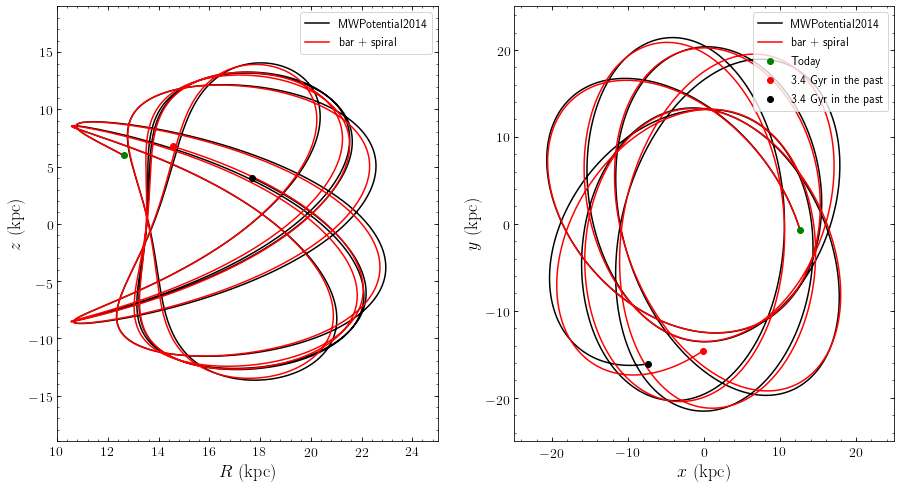

In [6]:
# plot orbit of GD-1 progenitor

gd1_prog_lb=[188.04928416766532, 51.848594007807456, 7.559027173643999, 12.260258757214746, -5.140630283489461, 7.162732847549563]

ts1=np.linspace(0.,-3.4,1000)/bovy_conversion.time_in_Gyr(220.,8.)

prog_orb0=Orbit(gd1_prog_lb,lb=True,ro=8.,vo=220.,solarmotion=[-11.1,24.,7.25])
prog_orb1=Orbit(gd1_prog_lb,lb=True,ro=8.,vo=220.,solarmotion=[-11.1,24.,7.25])

prog_orb0.integrate(ts1,MWPotential2014)
prog_orb1.integrate(ts1,MW_bar_spiral_pot)

bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(15,8)
subplot(1,2,1)
prog_orb0.plot(color='k',label='MWPotential2014',gcf=True,xrange=[10.,25.],yrange=[-19.,19.])
prog_orb1.plot(color='r',label='bar + spiral',overplot=True,gcf=True)
plot([prog_orb1.R()],[prog_orb1.z()],'go')
plot([prog_orb1.R(ts1[-1])],[prog_orb1.z(ts1[-1])],'ro')
plot([prog_orb0.R(ts1[-1])],[prog_orb0.z(ts1[-1])],'ko')
legend(loc='upper right')

subplot(1,2,2)
prog_orb0.plot(color='k',label='MWPotential2014',d1='x',d2='y',gcf=True,xrange=[-25,25.],yrange=[-25.,25.])
prog_orb1.plot(color='r',label='bar + spiral',overplot=True,gcf=True,d1='x',d2='y')
plot([prog_orb1.x()],[prog_orb1.y()],'go',label='Today')
plot([prog_orb1.x(ts1[-1])],[prog_orb1.y(ts1[-1])],'ro',label='3.4 Gyr in the past')
plot([prog_orb0.x(ts1[-1])],[prog_orb0.y(ts1[-1])],'ko',label='3.4 Gyr in the past')
legend(loc='upper right')
show()


There seems to be some deviations in the orbit in the presence of the bar+spiral potential. We will investigate 
whether this deviation affects the density of the stream.

### Run some samples in the streamdf and spraydf. Compare the length of the stream in the latter to get an estimate of the mass of the progenitor. $10^{5}$ M$_{\odot}$ seems to work well, same value used by Price-Whelan and Bonaca (2018).

In [ ]:
# Unperturbed streamdf
N=100
SCFbar_util_new.sample_streamdf_smooth(N,nobarpot,stream='GD1',prog=-40.,sigv=0.3,fo='sample_GD1_nobarpot_trailing.dat',write=True,trailing=True)
SCFbar_util_new.sample_streamdf_smooth(N,nobarpot,stream='GD1',prog=-40.,sigv=0.3,fo='sample_GD1_nobarpot_leading.dat',write=True,trailing=False)

#

In [ ]:
#perturbed streamdf
N=100
SCFbar_util_new.sample_streamdf_noprog(N,MW_bar_spiral_pot,nobarpot,stream='GD1',sigv=0.3,prog=-40.,fo='sample_GD1_bar_spiral_trailing.dat',write=True,trailing=True)
SCFbar_util_new.sample_streamdf_noprog(N,MW_bar_spiral_pot,nobarpot,stream='GD1',sigv=0.3,prog=-40.,fo='sample_GD1_bar_spiral_leading.dat',write=True,trailing=False)
    
    

In [ ]:
#perturbed spraydf
N=100
SCFbar_util_new.sample_spraydf(N,MW_bar_spiral_pot,stream='GD1',Mprogenitor = 10000.,prog=-40.,tage=3.2,fo='sample_spray_GD1_bar_spiral_trailing.dat',write=True,trailing=True)
SCFbar_util_new.sample_spraydf(N,MW_bar_spiral_pot,stream='GD1',Mprogenitor = 10000.,prog=-40.,tage=3.2,fo='sample_spray_GD1_bar_spiral_leading.dat',write=True,trailing=False)
    

In [ ]:
## perturbed spraydf noprog
N=100
SCFbar_util_new.sample_spraydf_noprog(N,MW_bar_spiral_pot,nobarpot,stream='GD1',prog=-40.,tage=3.2,Mprogenitor = 10000.,fo='sample_spray_noprog_GD1_bar_spiral_trailing.dat',write=True,trailing=True)
SCFbar_util_new.sample_spraydf_noprog(N,MW_bar_spiral_pot,nobarpot,stream='GD1',prog=-40.,tage=3.2,Mprogenitor = 10000.,fo='sample_spray_noprog_GD1_bar_spiral_leading.dat',write=True,trailing=False)


In [7]:
#coloring stuff

cmap= cm.plasma

def color_from_colormap(val,cmap,cmin,cmax):
    va=[]
    for v in val:
        va.append(cmap((v-cmin)/(cmax-cmin)))
        
    return va

def add_discrete_colorbar_dens(vmin,vmax,clabel,ticks,save_figures=False):
    fig= pyplot.gcf()
    if save_figures:
        cbar_ax = fig.add_axes([0.775,0.135,0.05,0.815])
    else:
        fig.subplots_adjust(right=0.9)
        cbar_ax = fig.add_axes([0.925, 0.13, 0.075, 0.83])
    tcmap = matplotlib.colors.ListedColormap([cmap(f) for f in numpy.linspace(0.,1.,len(ticks))])
    dtick= (ticks[1]-ticks[0])
    sm = pyplot.cm.ScalarMappable(cmap=tcmap,norm=pyplot.Normalize(vmin=vmin-0.5*dtick,vmax=vmax+0.5*dtick))
    sm._A = []
    cbar= fig.colorbar(sm,cax=cbar_ax,use_gridspec=True,format=r'$%.1f$',ticks=ticks)
    cbar.set_label(clabel)
    return None

def add_colorbar(vmin,vmax,clabel,save_figures=False):
    fig= pyplot.gcf()
    if save_figures:
        cbar_ax = fig.add_axes([0.9,0.135,0.025,0.815])
    else:
        fig.subplots_adjust(right=0.95)
        cbar_ax = fig.add_axes([0.975, 0.13, 0.025, 0.83])
    sm = pyplot.cm.ScalarMappable(cmap=cmap,norm=pyplot.Normalize(vmin=vmin,vmax=vmax))
    sm._A = []
    cbar= fig.colorbar(sm,cax=cbar_ax,use_gridspec=True,format=r'$%.1f$')
    cbar.set_label(clabel)
    return None

In [8]:
Rt_sm,phit_sm,zt_sm,vRt_sm,vTt_sm,vzt_sm,tt_sm=np.genfromtxt("GD1sample_GD1_nobarpot_trailing.dat",unpack=True)
Rl_sm,phil_sm,zl_sm,vRl_sm,vTl_sm,vzl_sm,tl_sm=np.genfromtxt("GD1sample_GD1_nobarpot_leading.dat",unpack=True)

Rt,phit,zt,vRt,vTt,vzt,tt=np.genfromtxt("GD1sample_GD1_bar_spiral_trailing.dat",unpack=True)
Rl,phil,zl,vRl,vTl,vzl,tl=np.genfromtxt("GD1sample_GD1_bar_spiral_leading.dat",unpack=True)

Rt_sp,phit_sp,zt_sp,vRt_sp,vTt_sp,vzt_sp,tt_sp=np.genfromtxt("GD1sample_spray_GD1_bar_spiral_trailing.dat",unpack=True)
Rl_sp,phil_sp,zl_sp,vRl_sp,vTl_sp,vzl_sp,tl_sp=np.genfromtxt("GD1sample_spray_GD1_bar_spiral_leading.dat",unpack=True)


Rt_spnp,phit_spnp,zt_spnp,vRt_spnp,vTt_spnp,vzt_spnp,tt_spnp=np.genfromtxt("GD1sample_spray_noprog_GD1_bar_spiral_trailing.dat",unpack=True)
Rl_spnp,phil_spnp,zl_spnp,vRl_spnp,vTl_spnp,vzl_spnp,tl_spnp=np.genfromtxt("GD1sample_spray_noprog_GD1_bar_spiral_leading.dat",unpack=True)



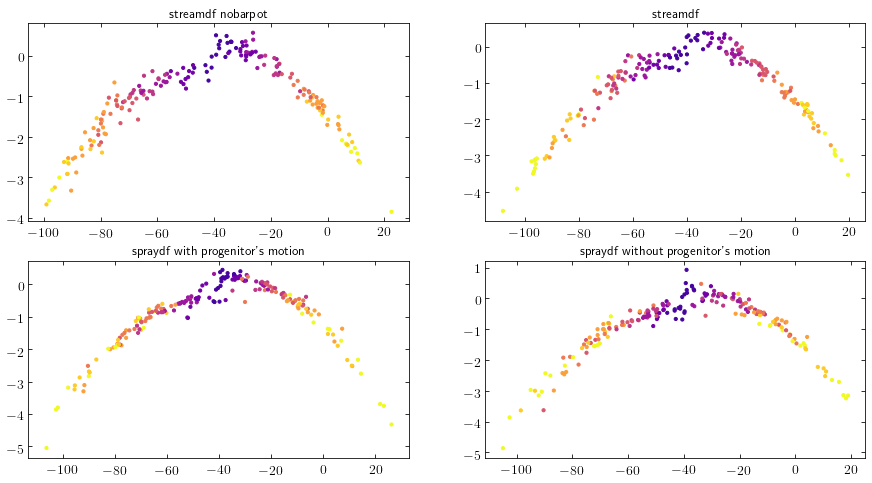

In [10]:
t_age= 3.2
dt_bins=np.linspace(0.,t_age,10)

def galcencyl_to_phi12(R,phi,Z,degree=True):
    l,b,d=np.array(galcencyl_to_lbd(R,phi,Z))
    phi12=lb_to_phi12(l,b,degree=True)
    phi1=phi12[:,0]
    phi1[phi1 > 180.]-=360.
    phi2=phi12[:,1]
    return (phi1,phi2)

p1_tsm,p2_tsm=galcencyl_to_phi12(Rt_sm,phit_sm,zt_sm)
p1_lsm,p2_lsm=galcencyl_to_phi12(Rl_sm,phil_sm,zl_sm)

p1_t,p2_t=galcencyl_to_phi12(Rt,phit,zt)
p1_l,p2_l=galcencyl_to_phi12(Rl,phil,zl)

p1_tsp,p2_tsp=galcencyl_to_phi12(Rt_sp,phit_sp,zt_sp)
p1_lsp,p2_lsp=galcencyl_to_phi12(Rl_sp,phil_sp,zl_sp)

p1_tspnp,p2_tspnp=galcencyl_to_phi12(Rt_spnp,phit_spnp,zt_spnp)
p1_lspnp,p2_lspnp=galcencyl_to_phi12(Rl_spnp,phil_spnp,zl_spnp)



dt_sm=numpy.digitize(tt_sm*bovy_conversion.time_in_Gyr(220.,8.),dt_bins)
dl_sm=numpy.digitize(tl_sm*bovy_conversion.time_in_Gyr(220.,8.),dt_bins)

dt=numpy.digitize(tt*bovy_conversion.time_in_Gyr(220.,8.),dt_bins)
dl=numpy.digitize(tl*bovy_conversion.time_in_Gyr(220.,8.),dt_bins)

dt_sp=numpy.digitize(tt_sp*bovy_conversion.time_in_Gyr(220.,8.),dt_bins)
dl_sp=numpy.digitize(tl_sp*bovy_conversion.time_in_Gyr(220.,8.),dt_bins)

dt_spnp=numpy.digitize(tt_spnp*bovy_conversion.time_in_Gyr(220.,8.),dt_bins)
dl_spnp=numpy.digitize(tl_spnp*bovy_conversion.time_in_Gyr(220.,8.),dt_bins)


plt.figure(figsize=(15,8))
plt.subplot(2,2,1)
plt.title('streamdf nobarpot')
plt.scatter(p1_tsm,p2_tsm,s=10,color=color_from_colormap(dt_sm,cmap,0.,9.))
plt.scatter(p1_lsm,p2_lsm,s=10,color=color_from_colormap(dl_sm,cmap,0.,9.))

plt.subplot(2,2,2)
plt.title('streamdf')
plt.scatter(p1_t,p2_t,s=10,color=color_from_colormap(dt,cmap,0.,9.))
plt.scatter(p1_l,p2_l,s=10,color=color_from_colormap(dl,cmap,0.,9.))

plt.subplot(2,2,3)
plt.title("spraydf with progenitor's motion")
plt.scatter(p1_tsp,p2_tsp,s=10,color=color_from_colormap(dt_sp,cmap,0.,9.))
plt.scatter(p1_lsp,p2_lsp,s=10,color=color_from_colormap(dl_sp,cmap,0.,9.))

plt.subplot(2,2,4)
plt.title("spraydf without progenitor's motion")
plt.scatter(p1_tspnp,p2_tspnp,s=10,color=color_from_colormap(dt_spnp,cmap,0.,9.))
plt.scatter(p1_lspnp,p2_lspnp,s=10,color=color_from_colormap(dl_spnp,cmap,0.,9.))

plt.show()
    
    
    

We ran 50000 samples for streamdf and spraydf (with and without progenitor's motion) cases, also in the spraydf case, we ran 50000 samples with nobarpot to see whether there are any intrinsic density variations. 

In [12]:
def process_sample(N,dir_trail):
    #dir_trail contains all the sample files from the trailing arm
    
    dir_lead = dir_trail.replace('trailing','leading')
    allfname_trail= glob.glob(dir_trail + '*.dat')
    allfname_lead= glob.glob(dir_lead + '*.dat')
    R_t=[]
    phi_t=[]
    z_t=[]
    vR_t=[]
    vT_t=[]
    vz_t=[]
    t_t=[]

    R_l=[]
    phi_l=[]
    z_l=[]
    vR_l=[]
    vT_l=[]
    vz_l=[]
    t_l=[]
     
    for i in range(N):
    #for i in range(10):
        try :
            R_t.append(numpy.loadtxt(allfname_trail[i])[:,0])
            phi_t.append(numpy.loadtxt(allfname_trail[i])[:,1])
            z_t.append(numpy.loadtxt(allfname_trail[i])[:,2])
            vR_t.append(numpy.loadtxt(allfname_trail[i])[:,3])
            vT_t.append(numpy.loadtxt(allfname_trail[i])[:,4])
            vz_t.append(numpy.loadtxt(allfname_trail[i])[:,5])
            t_t.append(numpy.loadtxt(allfname_trail[i])[:,6])
            
        except ValueError : 
            print (allfname_trail[i])
        
    for ii in range(N):
    #for ii in range(10): 
        try :
            R_l.append(numpy.loadtxt(allfname_lead[ii])[:,0])
            phi_l.append(numpy.loadtxt(allfname_lead[ii])[:,1])
            z_l.append(numpy.loadtxt(allfname_lead[ii])[:,2])
            vR_l.append(numpy.loadtxt(allfname_lead[ii])[:,3])
            vT_l.append(numpy.loadtxt(allfname_lead[ii])[:,4])
            vz_l.append(numpy.loadtxt(allfname_lead[ii])[:,5])
            t_l.append(numpy.loadtxt(allfname_lead[ii])[:,6])
            
        except ValueError : 
            print (allfname_lead[ii])
        
    Rall_t = np.array([item for sublist in R_t for item in sublist])
    phiall_t = np.array([item for sublist in phi_t for item in sublist])
    zall_t = np.array([item for sublist in z_t for item in sublist])
    vRall_t = np.array([item for sublist in vR_t for item in sublist])
    vTall_t = np.array([item for sublist in vT_t for item in sublist])
    vzall_t = np.array([item for sublist in vz_t for item in sublist])
    tall_t = np.array([item for sublist in t_t for item in sublist])

    Rall_l = np.array([item for sublist in R_l for item in sublist])
    phiall_l = np.array([item for sublist in phi_l for item in sublist])
    zall_l = np.array([item for sublist in z_l for item in sublist])
    vRall_l = np.array([item for sublist in vR_l for item in sublist])
    vTall_l = np.array([item for sublist in vT_l for item in sublist])
    vzall_l = np.array([item for sublist in vz_l for item in sublist])
    tall_l = np.array([item for sublist in t_l for item in sublist])
    
    #x_l,y_l,z_l=bovy_coords.cyl_to_rect(Rall_l,phiall_l,zall_l)
    
    l_t,b_t,d_t=np.array(galcencyl_to_lbd(Rall_t,phiall_t,zall_t))
    l_l,b_l,d_l=np.array(galcencyl_to_lbd(Rall_l,phiall_l,zall_l))
    
    #radec_t=bovy_coords.lb_to_radec(l_t,b_t,degree=True) 
    #radec_l=bovy_coords.lb_to_radec(l_l,b_l,degree=True)
      
    phi12_l=lb_to_phi12(l_l,b_l,degree=True)
    phi12_t=lb_to_phi12(l_t,b_t,degree=True)

    phi1_l=phi12_l[:,0]
    phi1_l[phi1_l > 180.]-=360.
    phi2_l=phi12_l[:,1]
    
    phi1_t=phi12_t[:,0]
    phi1_t[phi1_t > 180.]-=360.
    phi2_t=phi12_t[:,1]
    
    return (phi1_l, phi2_l, phi1_t, phi2_t)

In [13]:
#perturbed streamdf
dir0='sampled_bar_spiral/bar_spiral/trailing/'
p1_l, p2_l, p1_t, p2_t = process_sample(101,dir0)

#perturbed spraydf with progenitor's motions
dir1='sampled_bar_spiral/spraydf_bar_spiral/trailing/'
p1_lsp, p2_lsp, p1_tsp, p2_tsp = process_sample(101,dir1)

#perturbed spraydf without progenitor's motions
dir2='sampled_bar_spiral/spraydf_noprog_bar_spiral/trailing/'
p1_lspnp, p2_lspnp, p1_tspnp, p2_tspnp = process_sample(101,dir2)

#smooth spraydf
dir3='sampled_bar_spiral/spraydf_nobarpot/trailing/'
p1_lspsm, p2_lspsm, p1_tspsm, p2_tspsm = process_sample(101,dir3)


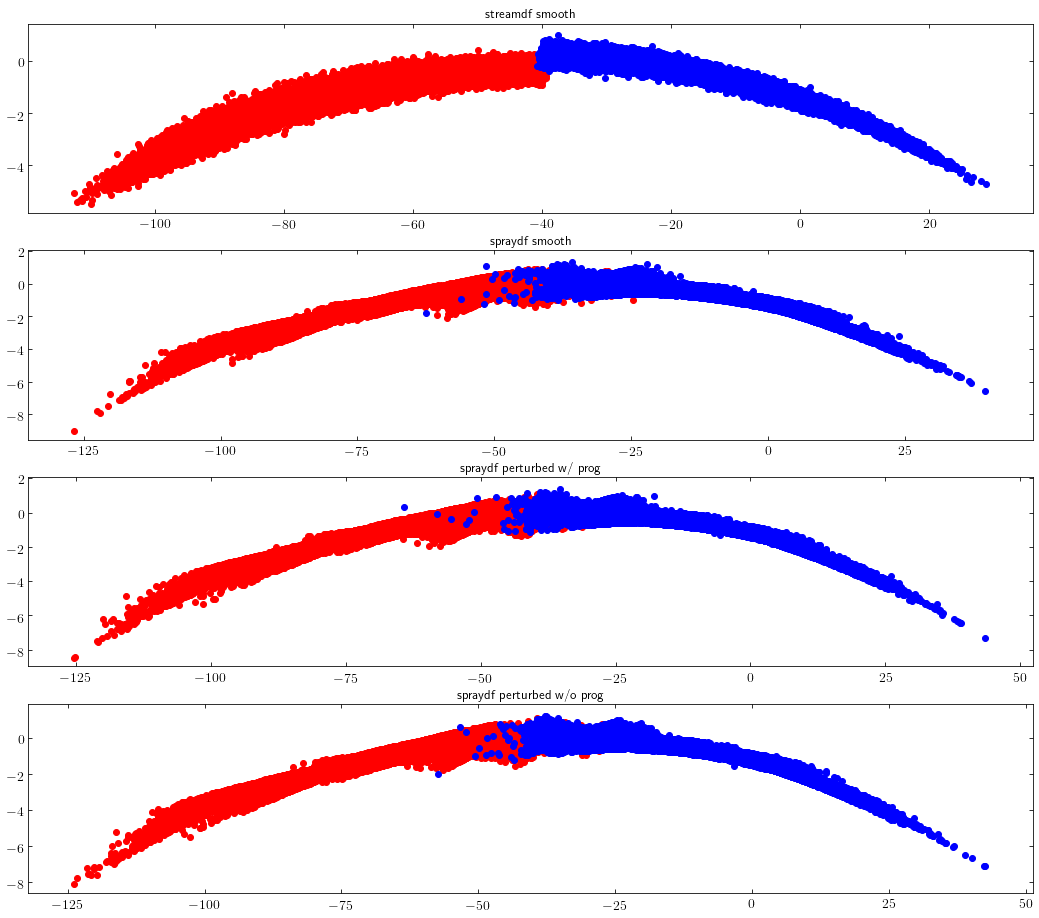

In [30]:
plt.figure(figsize=(18,16))

subplot(4,1,1)
plt.title('streamdf smooth')
plt.scatter(p1_l,p2_l,c='r')
plt.scatter(p1_t,p2_t,c='b')

subplot(4,1,2)
plt.title('spraydf smooth')
plt.scatter(p1_lspsm,p2_lspsm,c='r')
plt.scatter(p1_tspsm,p2_tspsm,c='b')

subplot(4,1,3)
plt.title('spraydf perturbed w/ prog')
plt.scatter(p1_lsp,p2_lsp,c='r')
plt.scatter(p1_tsp,p2_tsp,c='b')

subplot(4,1,4)
plt.title('spraydf perturbed w/o prog')
plt.scatter(p1_lspnp,p2_lspnp,c='r')
plt.scatter(p1_tspnp,p2_tspnp,c='b')
plt.show()

In [17]:
def compute_ndenphi1(phi1,maxphi1=-42,minphi1=-60.,bw=2.,polydeg=3):
    N=len(phi1)
    print (N)
    
    nbins= (maxphi1 - minphi1)/bw
    print ("no of xi bins = %i"%nbins)

    phi1bin_edge=[(minphi1-0.5*bw) + i*bw for i in range(int(nbins)+2)]
    #print (xibin_edge)
    midphi1=[0.5*(phi1bin_edge[i] + phi1bin_edge[i+1]) for i in range(int(nbins)+1)]
    
    Ndn=np.histogram(phi1,phi1bin_edge)[0]
    print (np.sum(Ndn))
    Ndn_err=numpy.sqrt(Ndn)
       
    pp= Polynomial.fit(midphi1,Ndn,deg=polydeg,w=1/(Ndn_err))
    nden=Ndn/pp(np.array(midphi1))
    nden_err=np.sqrt(Ndn)/pp(np.array(midphi1))
        
    
    return (midphi1,Ndn,Ndn_err,nden,nden_err,pp(np.array(midphi1)))

### Plot the density and power in the three cases, i.e., spraydf : {smooth, perturbed w/ prog, perturbed w/o prog}

In [31]:
midphi1,Ndn,Ndn_err,nden,nden_err,pp = compute_ndenphi1(p1_l,maxphi1=-42.,minphi1=-60.)
midphi1_t,Ndn_t,Ndn_err_t,nden_t,nden_err_t,pp_t = compute_ndenphi1(p1_t,maxphi1=-5.,minphi1=-38.)

midphi1sp,Ndnsp,Ndn_errsp,ndensp,nden_errsp,ppsp = compute_ndenphi1(p1_lsp,maxphi1=-42.,minphi1=-60.)
midphi1sp_t,Ndnsp_t,Ndn_errsp_t,ndensp_t,nden_errsp_t,ppsp_t = compute_ndenphi1(p1_tsp,maxphi1=-5.,minphi1=-38.)

midphi1spnp,Ndnspnp,Ndn_errspnp,ndenspnp,nden_errspnp,ppspnp = compute_ndenphi1(p1_lspnp,maxphi1=-42.,minphi1=-60.)
midphi1spnp_t,Ndnspnp_t,Ndn_errspnp_t,ndenspnp_t,nden_errspnp_t,ppspnp_t = compute_ndenphi1(p1_tspnp,maxphi1=-5.,minphi1=-38.)

midphi1spsm,Ndnspsm,Ndn_errspsm,ndenspsm,nden_errspsm,ppspsm = compute_ndenphi1(p1_lspsm,maxphi1=-42.,minphi1=-60.)
midphi1spsm_t,Ndnspsm_t,Ndn_errspsm_t,ndenspsm_t,nden_errspsm_t,ppspsm_t = compute_ndenphi1(p1_tspsm,maxphi1=-5.,minphi1=-38.)

50010
no of xi bins = 9
16756
50010
no of xi bins = 16
30974
50500
no of xi bins = 9
22464
50500
no of xi bins = 16
38268
50500
no of xi bins = 9
23339
50500
no of xi bins = 16
38338
50500
no of xi bins = 9
22662
50500
no of xi bins = 16
38359


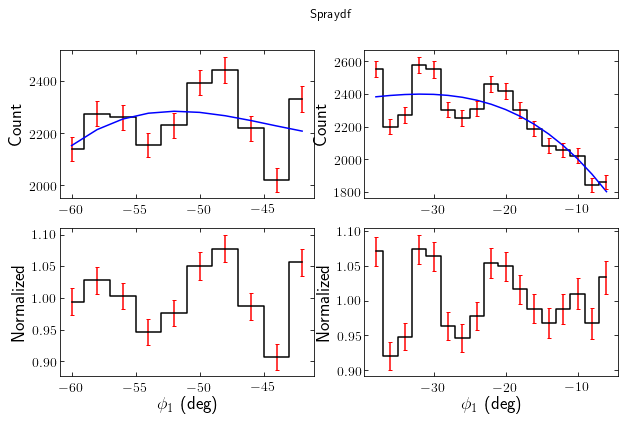

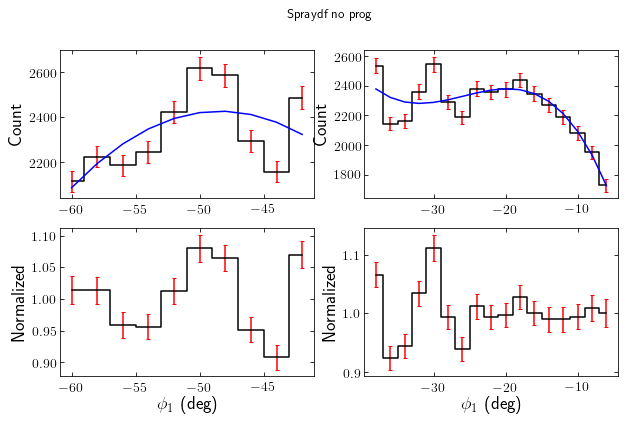

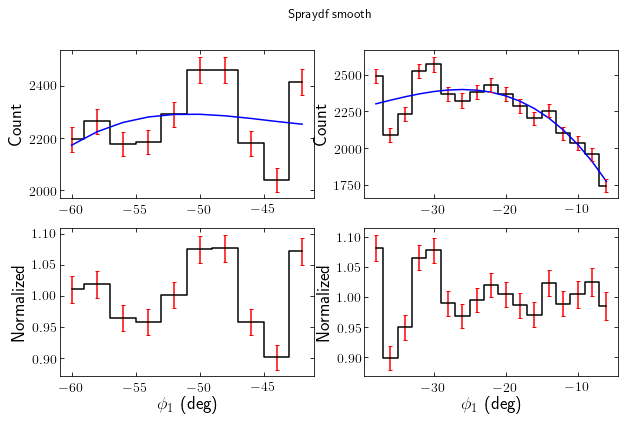

In [19]:
plt.figure(figsize=(10,6))
plt.suptitle('Spraydf')
plt.subplot(2,2,1)
plt.plot(midphi1sp,Ndnsp,ls='steps-mid',c='k')
plt.plot(midphi1sp,ppsp,c='b',label=r'$3^{\rm{rd}}$ order polynomial')
plt.errorbar(midphi1sp,Ndnsp,Ndn_errsp,marker='None',ls='None',capsize=2.,ecolor='r')
plt.ylabel('Count')

plt.subplot(2,2,2)
plt.plot(midphi1sp_t,Ndnsp_t,ls='steps-mid',c='k')
plt.plot(midphi1sp_t,ppsp_t,c='b',label=r'$3^{\rm{rd}}$ order polynomial')
plt.errorbar(midphi1sp_t,Ndnsp_t,Ndn_errsp_t,marker='None',ls='None',capsize=2.,ecolor='r')
plt.ylabel('Count')

plt.subplot(2,2,3)
plt.plot(midphi1sp,ndensp,ls='steps-mid',c='k')
plt.errorbar(midphi1sp,ndensp,nden_errsp,marker='None',capsize=2.,ls='None',ecolor='r')
plt.ylabel('Normalized')
plt.xlabel(r'$\phi_{1}$ (deg)')

plt.subplot(2,2,4)
plt.plot(midphi1sp_t,ndensp_t,ls='steps-mid',c='k')
plt.errorbar(midphi1sp_t,ndensp_t,nden_errsp_t,marker='None',capsize=2.,ls='None',ecolor='r')
plt.ylabel('Normalized')
plt.xlabel(r'$\phi_{1}$ (deg)')

plt.show()


plt.figure(figsize=(10,6))
plt.suptitle('Spraydf no prog')
plt.subplot(2,2,1)
plt.plot(midphi1spnp,Ndnspnp,ls='steps-mid',c='k')
plt.plot(midphi1spnp,ppspnp,c='b',label=r'$3^{\rm{rd}}$ order polynomial')
plt.errorbar(midphi1spnp,Ndnspnp,Ndn_errspnp,marker='None',ls='None',capsize=2.,ecolor='r')
plt.ylabel('Count')

plt.subplot(2,2,2)
plt.plot(midphi1spnp_t,Ndnspnp_t,ls='steps-mid',c='k')
plt.plot(midphi1spnp_t,ppspnp_t,c='b',label=r'$3^{\rm{rd}}$ order polynomial')
plt.errorbar(midphi1spnp_t,Ndnspnp_t,Ndn_errspnp_t,marker='None',ls='None',capsize=2.,ecolor='r')
plt.ylabel('Count')

plt.subplot(2,2,3)
plt.plot(midphi1spnp,ndenspnp,ls='steps-mid',c='k')
plt.errorbar(midphi1spnp,ndenspnp,nden_errspnp,marker='None',capsize=2.,ls='None',ecolor='r')
plt.ylabel('Normalized')
plt.xlabel(r'$\phi_{1}$ (deg)')

plt.subplot(2,2,4)
plt.plot(midphi1spnp_t,ndenspnp_t,ls='steps-mid',c='k')
plt.errorbar(midphi1spnp_t,ndenspnp_t,nden_errspnp_t,marker='None',capsize=2.,ls='None',ecolor='r')
plt.ylabel('Normalized')
plt.xlabel(r'$\phi_{1}$ (deg)')

plt.show()

plt.figure(figsize=(10,6))
plt.suptitle('Spraydf smooth')
plt.subplot(2,2,1)
plt.plot(midphi1spsm,Ndnspsm,ls='steps-mid',c='k')
plt.plot(midphi1spsm,ppspsm,c='b',label=r'$3^{\rm{rd}}$ order polynomial')
plt.errorbar(midphi1spsm,Ndnspsm,Ndn_errspsm,marker='None',ls='None',capsize=2.,ecolor='r')
plt.ylabel('Count')

plt.subplot(2,2,2)
plt.plot(midphi1spsm_t,Ndnspsm_t,ls='steps-mid',c='k')
plt.plot(midphi1spsm_t,ppspsm_t,c='b',label=r'$3^{\rm{rd}}$ order polynomial')
plt.errorbar(midphi1spsm_t,Ndnspsm_t,Ndn_errspsm_t,marker='None',ls='None',capsize=2.,ecolor='r')
plt.ylabel('Count')

plt.subplot(2,2,3)
plt.plot(midphi1spsm,ndenspsm,ls='steps-mid',c='k')
plt.errorbar(midphi1spsm,ndenspsm,nden_errspsm,marker='None',capsize=2.,ls='None',ecolor='r')
plt.ylabel('Normalized')
plt.xlabel(r'$\phi_{1}$ (deg)')

plt.subplot(2,2,4)
plt.plot(midphi1spsm_t,ndenspsm_t,ls='steps-mid',c='k')
plt.errorbar(midphi1spsm_t,ndenspsm_t,nden_errspsm_t,marker='None',capsize=2.,ls='None',ecolor='r')
plt.ylabel('Normalized')
plt.xlabel(r'$\phi_{1}$ (deg)')

plt.show()

Even the smooth stream seems to have quite some density variations. However, the important point is that the perturbed stream also has density variations at similar level as the smooth stream implying negligible effect from the bar+spiral potential, so that's good. 
For completeness, let's plot the power spectrum below and compare the power. 

In [20]:
def compute_Pk(phi1,norm_den,norm_den_err):
    px_dat,py_dat= signal.csd(norm_den,norm_den,fs=1./(phi1[1]-phi1[0]),scaling='spectrum',nperseg=len(phi1))
    py_dat= py_dat.real
    px_dat= 1./px_dat
    py_dat= numpy.sqrt(py_dat*(phi1[-1]-phi1[0]))
           
    # Perform simulations of the noise to determine the power in the noise
    nerrsim= 10000
    ppy_err_dat= numpy.empty((nerrsim,len(px_dat)))

    for ii in range(nerrsim):
        tmock= norm_den_err*numpy.random.normal(size=len(phi1))
        ppy_err_dat[ii]= signal.csd(tmock,tmock,
                                fs=1./(phi1[1]-phi1[0]),scaling='spectrum',
                                nperseg=len(phi1))[1].real

    py_err_dat= numpy.sqrt(numpy.median(ppy_err_dat,axis=0)*(phi1[-1]-phi1[0]))
    return (px_dat,py_dat,py_err_dat)

def set_ranges_and_labels_dens():
    
    xlabel(r'$1/k_{\phi_{1}}\,(\mathrm{deg})$',size=18)
    ylim(0.001,10.)
    xlim(1,100.)
    for axis in [gca().xaxis,gca().yaxis]:
        axis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    return None

In [37]:
px_l,py_l,py_err_l=compute_Pk(midphi1,nden,nden_err)
px_t,py_t,py_err_t=compute_Pk(midphi1_t,nden_t,nden_err_t)

pxsp_l,pysp_l,py_errsp_l=compute_Pk(midphi1sp,ndensp,nden_errsp)
pxsp_t,pysp_t,py_errsp_t=compute_Pk(midphi1sp_t,ndensp_t,nden_errsp_t)

pxnp_l,pynp_l,pynp_err_l=compute_Pk(midphi1spnp,ndenspnp,nden_errspnp)
pxnp_t,pynp_t,pynp_err_t=compute_Pk(midphi1spnp_t,ndenspnp_t,nden_errspnp_t)

pxspsm_l,pyspsm_l,pyspsm_err_l=compute_Pk(midphi1spsm,ndenspsm,nden_errspsm)
pxspsm_t,pyspsm_t,pyspsm_err_t=compute_Pk(midphi1spsm_t,ndenspsm_t,nden_errspsm_t)

/home/nil/anaconda3/envs/galpy1.4/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.



Text(0,0.5,'$\\sqrt{P_{\\delta\\delta}(k_{\\phi_{1}})}$')

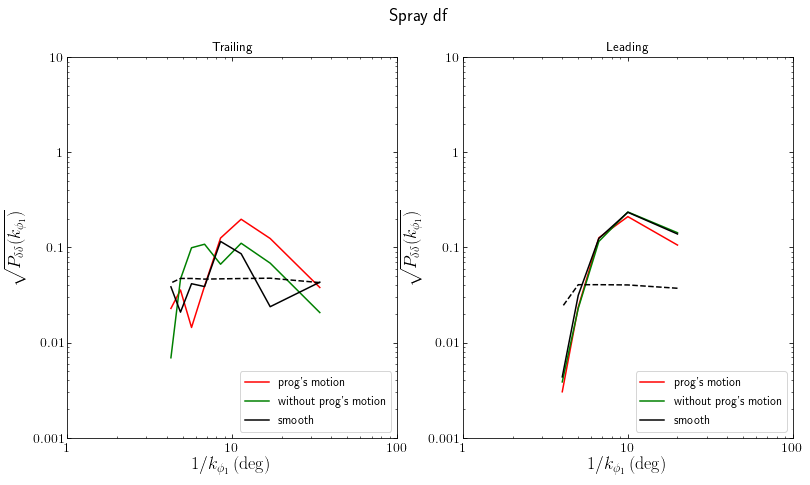

In [38]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(13,7)
suptitle('Spray df',fontsize=18)
subplot(1,2,1)
title('Trailing')
loglog(px_t,pysp_t,color='r',zorder=1,label="prog's motion")
loglog(px_t,pynp_t,color='g',zorder=1,label="without prog's motion")
loglog(px_t,pyspsm_t,color='k',zorder=1,label="smooth")

loglog(px_t,py_err_t,color='k',ls='--',zorder=1)
legend(loc='lower right')
set_ranges_and_labels_dens()
plt.ylabel(r'$\sqrt{P_{\delta\delta}(k_{\phi_{1}})}$',fontsize=18)

subplot(1,2,2)
title('Leading')
loglog(px_l,pysp_l,color='r',zorder=1,label="prog's motion")
loglog(px_l,pynp_l,color='g',zorder=1,label="without prog's motion")
loglog(px_l,pyspsm_l,color='k',zorder=1,label="smooth")
loglog(px_l,py_errsp_l,color='k',ls='--',zorder=1)
legend(loc='lower right')
set_ranges_and_labels_dens()
plt.ylabel(r'$\sqrt{P_{\delta\delta}(k_{\phi_{1}})}$',fontsize=18)
#savefig('plots/GD-1_power_gaia.pdf')

As noted above, there seems to be no additional density power induced by the bar+spiral combination. Let's see how the results look for the streamdf case below.

50010
no of xi bins = 9
16756
50010
no of xi bins = 16
30974


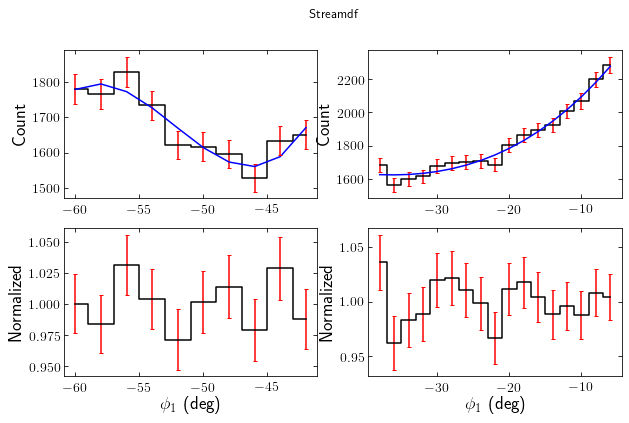

In [36]:
#perturbed streamdf
plt.figure(figsize=(10,6))
plt.suptitle('Streamdf')
plt.subplot(2,2,1)
plt.plot(midphi1,Ndn,ls='steps-mid',c='k')
plt.plot(midphi1,pp,c='b',label=r'$3^{\rm{rd}}$ order polynomial')
plt.errorbar(midphi1,Ndn,Ndn_err,marker='None',ls='None',capsize=2.,ecolor='r')
plt.ylabel('Count')

plt.subplot(2,2,2)
plt.plot(midphi1_t,Ndn_t,ls='steps-mid',c='k')
plt.plot(midphi1_t,pp_t,c='b',label=r'$3^{\rm{rd}}$ order polynomial')
plt.errorbar(midphi1_t,Ndn_t,Ndn_err_t,marker='None',ls='None',capsize=2.,ecolor='r')
plt.ylabel('Count')

plt.subplot(2,2,3)
plt.plot(midphi1,nden,ls='steps-mid',c='k')
plt.errorbar(midphi1,nden,nden_err,marker='None',capsize=2.,ls='None',ecolor='r')
plt.ylabel('Normalized')
plt.xlabel(r'$\phi_{1}$ (deg)')

plt.subplot(2,2,4)
plt.plot(midphi1_t,nden_t,ls='steps-mid',c='k')
plt.errorbar(midphi1_t,nden_t,nden_err_t,marker='None',capsize=2.,ls='None',ecolor='r')
plt.ylabel('Normalized')
plt.xlabel(r'$\phi_{1}$ (deg)')

plt.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Text(0,0.5,'$\\sqrt{P_{\\delta\\delta}(k_{\\phi_{1}})}$')

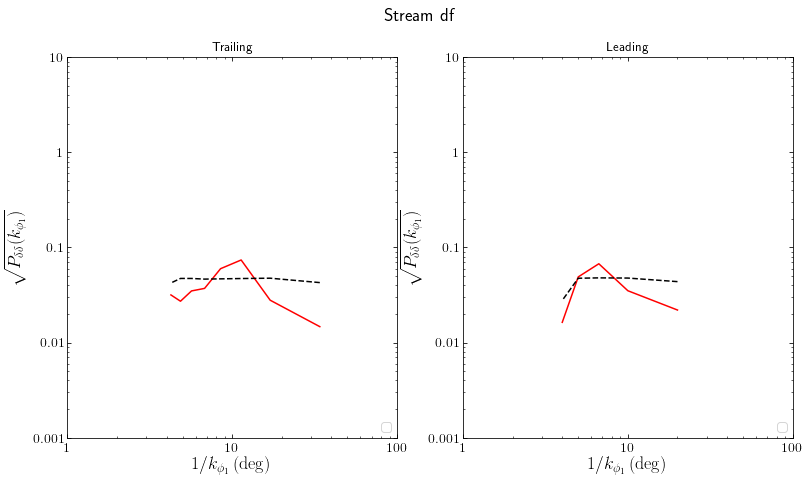

In [39]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(13,7)
suptitle('Stream df',fontsize=18)
subplot(1,2,1)
title('Trailing')
loglog(px_t,py_t,color='r',zorder=1)

loglog(px_t,py_err_t,color='k',ls='--',zorder=1)
legend(loc='lower right')
set_ranges_and_labels_dens()
plt.ylabel(r'$\sqrt{P_{\delta\delta}(k_{\phi_{1}})}$',fontsize=18)

subplot(1,2,2)
title('Leading')
loglog(px_l,py_l,color='r',zorder=1)
loglog(px_l,py_err_l,color='k',ls='--',zorder=1)
legend(loc='lower right')
set_ranges_and_labels_dens()
plt.ylabel(r'$\sqrt{P_{\delta\delta}(k_{\phi_{1}})}$',fontsize=18)